# CO543: Image Processing - Lab 2 (2025)
### E/21/245 - MADHUSHAN S.K.A.K.

## Task 1 — Visualize Intensity & Histograms

importing the relevent libraries

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

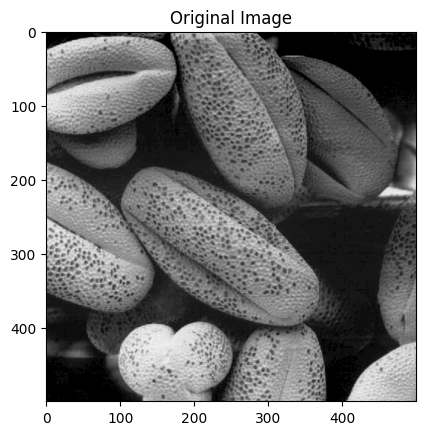

In [4]:
img =cv2.imread('dark.tif',0)
plt.imshow(img, cmap='gray')
plt.title('Original Image')
plt.show()


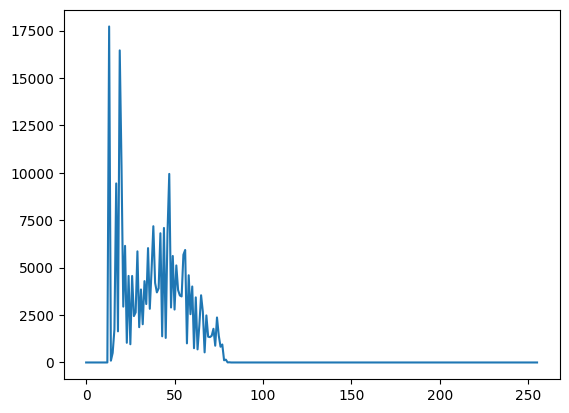

In [5]:
# cv2.calcHist(images, channels, mask, histSize, ranges[, hist[, accumulate]])
hist = cv2.calcHist([img], [0], None , [256], [0,256])
plt.plot(hist)

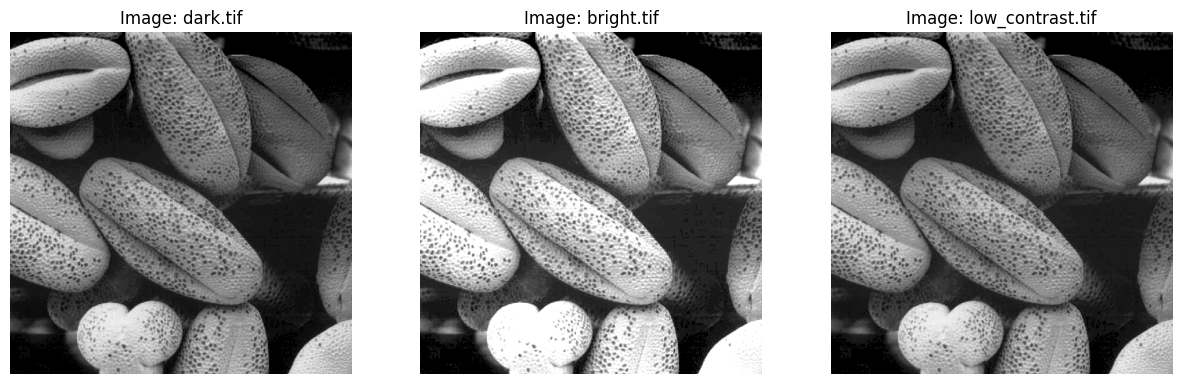

In [6]:
image_files = ['dark.tif', 'bright.tif', 'low_contrast.tif']
plt.figure(figsize=(15,5))

for i, filename in enumerate(image_files):
    img_ = cv2.imread(filename, 0)

    if img_ is None:
        print(f"Error: Could not open or find the image {filename}.")
        continue
    plt.subplot(1, len(image_files), i+1)
    plt.imshow(img_, cmap='gray')
    plt.title(f'Image: {filename}')
    plt.axis('off')
plt.show()

Let see all the given images to see how the histrogram is drawn

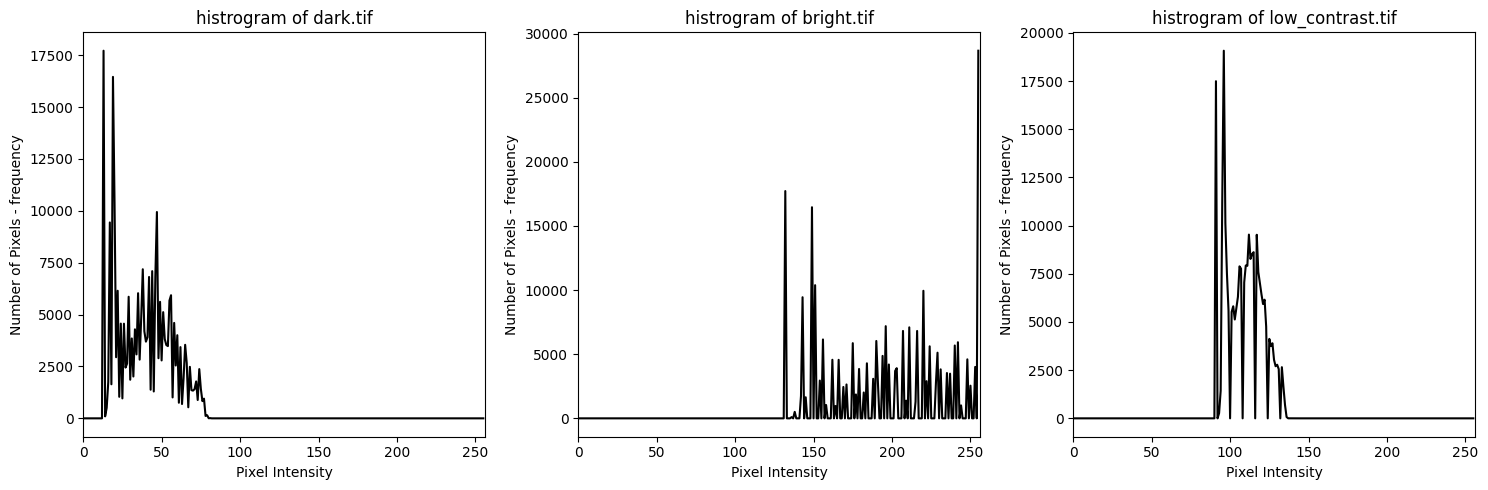

In [11]:
plt.figure(figsize=(15,5))

for i, filename in enumerate(image_files):
    img_ = cv2.imread(filename, 0)

    if img_ is None:
        print(f"Error: Could not open or find the image {filename}.")
        continue
    hist = cv2.calcHist([img_], [0], None , [256], [0,256])

    plt.subplot(1, len(image_files), i+1)
    plt.title(f"histrogram of {filename}")
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Number of Pixels - frequency')
    plt.plot(hist, color='black')
    plt.xlim([0,256])
plt.tight_layout()
plt.show()

### Observations

When I plotted the histograms for the three images, I immediately noticed a clear link between the graph shape and the image quality. For the dark image, the pixel data was clustered heavily on the left side, which I suppose makes sense since those are the low intensity values. In contrast, the bright image showed a distribution pushed way over to the right. I thought the most interesting one was the low contrast image; its histogram was just a narrow spike in the middle, showing that it lacked any deep blacks or bright whites. As I see it, checking this distribution is essential because it mathematically confirms the lighting conditions before I decide how to process or enhance the image.

### More to think:​
**If two images have similar histograms, can they still look visually different? Why?**

Yes, absolutely.

The Logic:- A histogram contains only statistical information (the count of pixels), but it contains zero spatial information (the location of pixels).he histogram tells you what is in the image, but not where it is.

## Task 2 — Manual Threshold & Observe Failure Cases

In [8]:

fixed_thresh_value = 100 

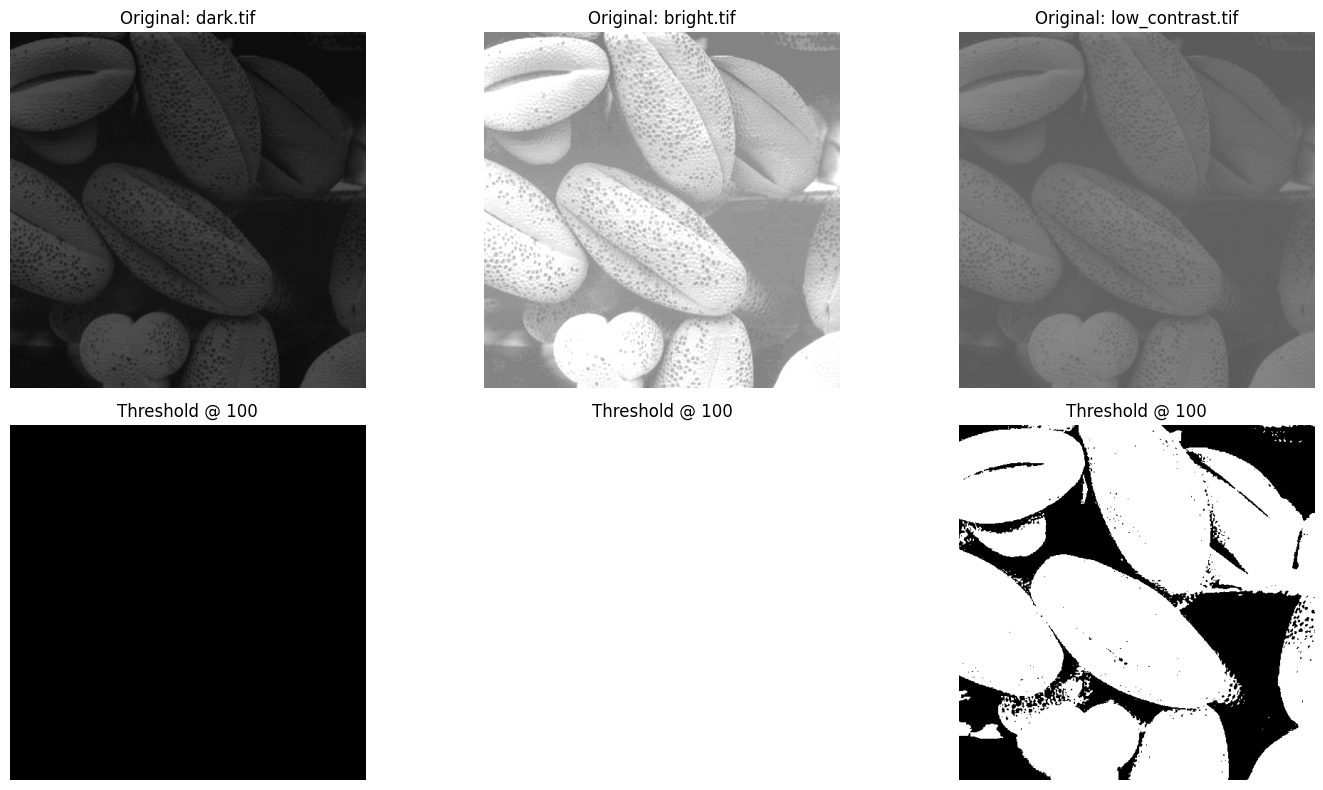

In [9]:

fig, axes = plt.subplots(2, 3, figsize=(15, 8)) 

for i, filename in enumerate(image_files):
    img = cv2.imread(filename, 0)
    
    # Thresholding
    _, binary_img = cv2.threshold(img, fixed_thresh_value, 255, cv2.THRESH_BINARY)
    
    # Plot Original (Top Row)
    axes[0, i].imshow(img, cmap='gray', vmin=0, vmax=255)
    axes[0, i].set_title(f"Original: {filename}")
    axes[0, i].axis('off')

    # Plot Thresholded (Bottom Row)
    axes[1, i].imshow(binary_img, cmap='gray', vmin=0, vmax=255)
    axes[1, i].set_title(f"Threshold @ {fixed_thresh_value}")
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()

### Observations

I applied a fixed threshold of 100 to all three images to test if a single value could handle different lighting. The results showed a complete failure for the extreme cases. For the 'dark.tif' image, the result was a completely black square because all pixels were below 100. Conversely, 'bright.tif' became a solid white square because its pixel values were all above the threshold. Only the 'low_contrast.tif' image showed identifiable objects, but the segmentation was still rough. This visually confirms that we cannot use a static threshold for dynamic lighting conditions; the threshold must adapt to the image data.

### More to think:​
Is thresholding really “deciding” what an object is, or just comparing brightness?

Answer:-  It is definitely just comparing brightness

The Logic:- Thresholding is a "dumb" operation. It follows a simple if/else statement
(like If intensity > T give that to 1 and else 0) Thresholding does not recognize objects; it only isolates intensity. Recognition comes later with more advanced algorithms (like contour detection or neural networks).

## Task 3 — Apply Otsu & Adaptive Thresholding

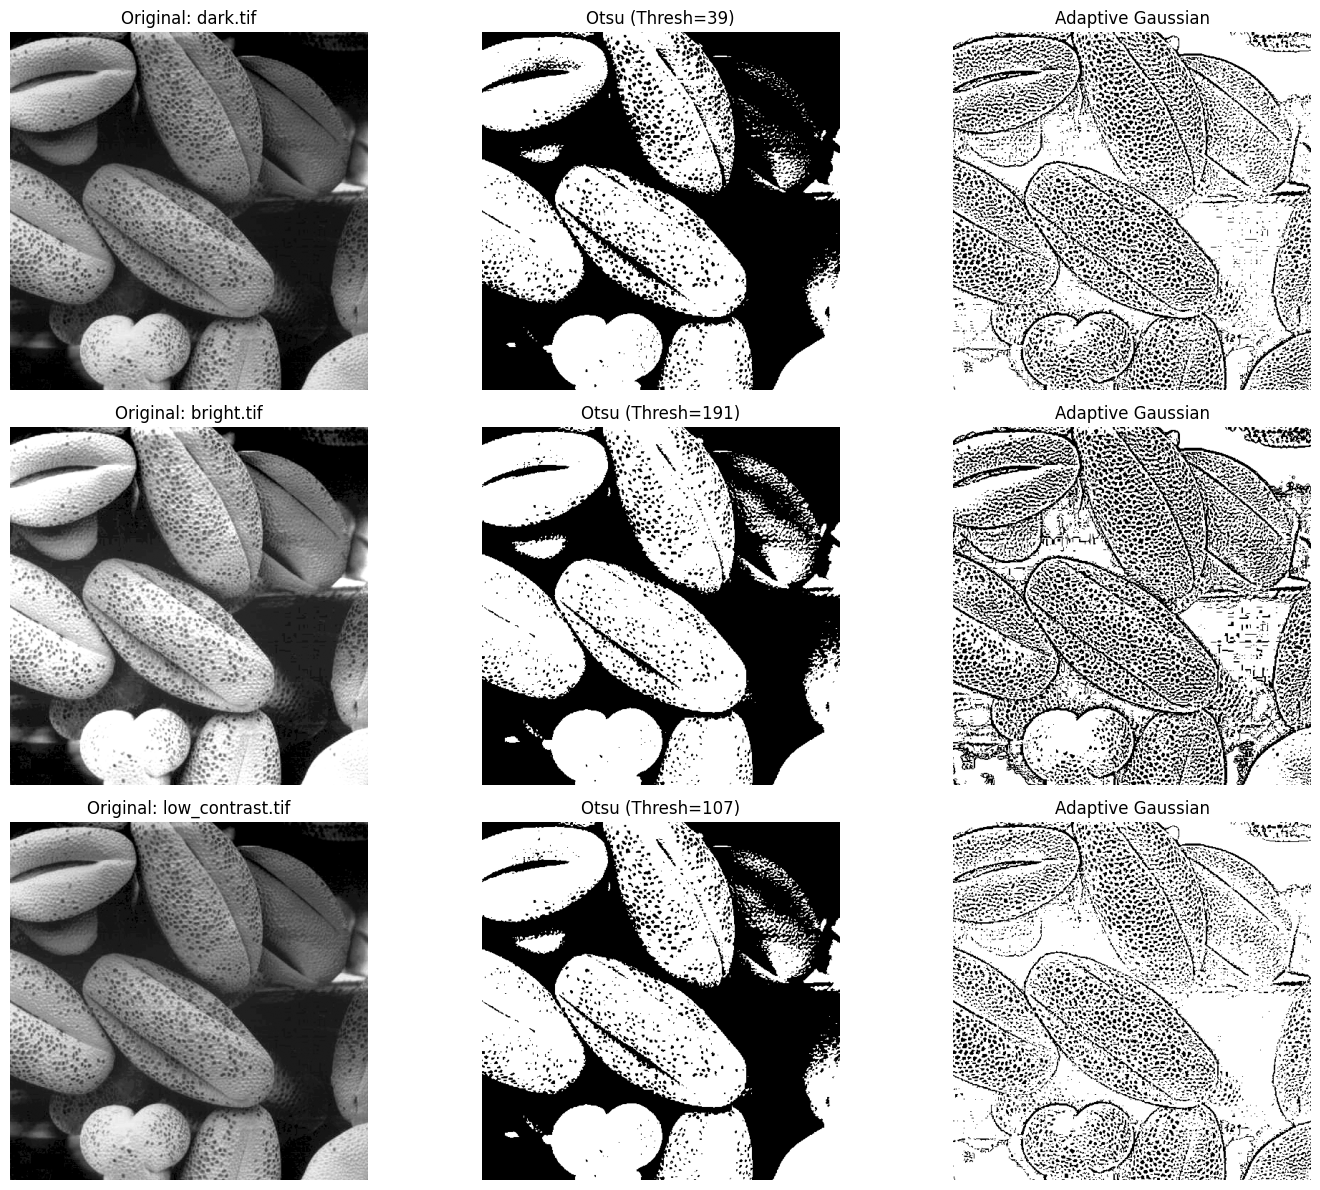

In [10]:

fig, axes = plt.subplots(3, 3, figsize=(15, 12)) 

for i, filename in enumerate(image_files):
    img = cv2.imread(filename, 0)

    # Method 1 - Otsu's Thresholding
    ret, otsu = cv2.threshold(img, 0, 255 , cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    #Method 2 - Adaptive Thresholding 
    adaptive = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)

    # 1. Original image 
    axes[i, 0].imshow(img, cmap='gray')
    axes[i, 0].set_title(f"Original: {filename}")
    axes[i, 0].axis('off')
    
    # 2. Otsu (Global Smart) images
    axes[i, 1].imshow(otsu, cmap='gray')
    axes[i, 1].set_title(f"Otsu (Thresh={int(ret)})") # Shows the number it chose!
    axes[i, 1].axis('off')
    
    # 3. Adaptive (Local Smart) images
    axes[i, 2].imshow(adaptive, cmap='gray')
    axes[i, 2].set_title("Adaptive Gaussian")
    axes[i, 2].axis('off')

plt.tight_layout()
plt.show()

### Observations

I compared the manual way with Otsu and Adaptive thresholding, and the difference was big. Before, I used one fixed number and it failed. But Otsu's method is smart; it found the best number for each image automatically. For example, it picked 39 for the dark image and 191 for the bright one. This made the object shapes look solid and clear. Then I tried Adaptive thresholding. It works differently. It looks at small details, so I could see the texture on the surface. But the problem is, it also created a lot of noise in the background that Otsu didn't have.

### More to think
Why can adaptive thresholding still struggle on textured backgrounds?

Answer:- 
I think the reason is that the algorithm looks at the image too closely. It checks every small area to find differences in brightness. If the background has a rough texture, it has tiny shadows and highlights. The algorithm mistakes these tiny shadows for actual objects or edges. So, instead of ignoring the background, it tries to outline every little bump, which creates a messy, noisy image.

In [12]:
img_dark = cv2.imread('dark.tif', 0)
img_bright = cv2.imread('bright.tif', 0)

In [21]:
# Gamma Correction (dark image -> Brighten)
gamma_low = 0.7 # Gamma < 1 makes things brighter
gamma_high = 2.0 # Gamma > 1 makes things darker

In [23]:
dark_img_corrected = np.power(img_dark / 255.0, gamma_low) * 255.0
dark_img_corrected = np.uint8(dark_img_corrected) # Convert back to standard image format

In [24]:
bright_img_corrected = np.power(img_bright / 255.0, gamma_high) * 255.0
bright_img_corrected = np.uint8(bright_img_corrected) # Convert back to standard image format

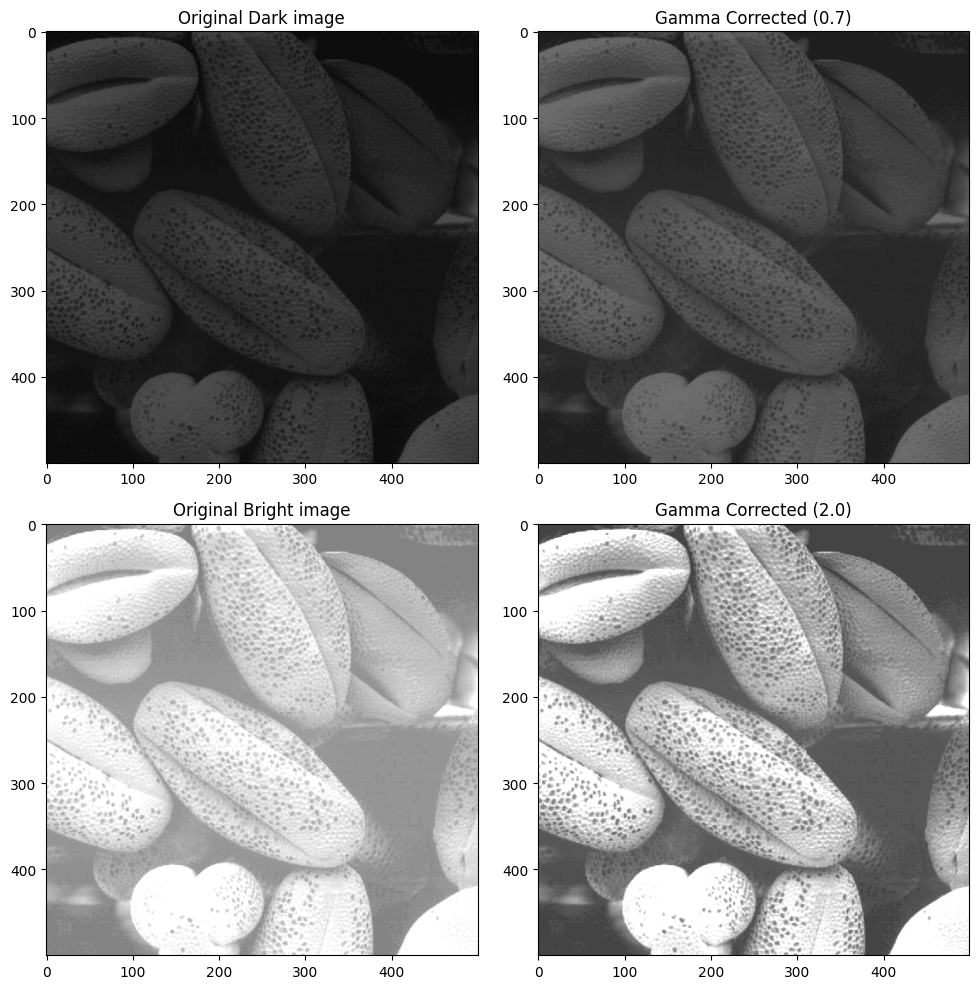

In [25]:
# Visualizing the p;ots
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

# Plot Dark Correction
axes[0,0].imshow(img_dark, cmap='gray', vmin=0, vmax=255)
axes[0,0].set_title("Original Dark image")
axes[0,1].imshow(dark_img_corrected, cmap='gray', vmin=0, vmax=255)
axes[0,1].set_title(f"Gamma Corrected ({gamma_low})")

# Plot Bright Correction
axes[1,0].imshow(img_bright, cmap='gray', vmin=0, vmax=255)
axes[1,0].set_title("Original Bright image")
axes[1,1].imshow(bright_img_corrected, cmap='gray', vmin=0, vmax=255)
axes[1,1].set_title(f"Gamma Corrected ({gamma_high})")

plt.tight_layout()
plt.show()

### Observations
First, I used Gamma correction to fix the exposure issues. For the dark image, I used a Gamma value of 0.7. This worked like a digital flash, brightening the hidden details without washing out the image. For the bright image, I used a Gamma of 2.0, which darkened the highlights and brought back the texture that was lost in the glare. I think this is really useful because it mimics how a camera adjusts exposure, letting us balance the light mathematically